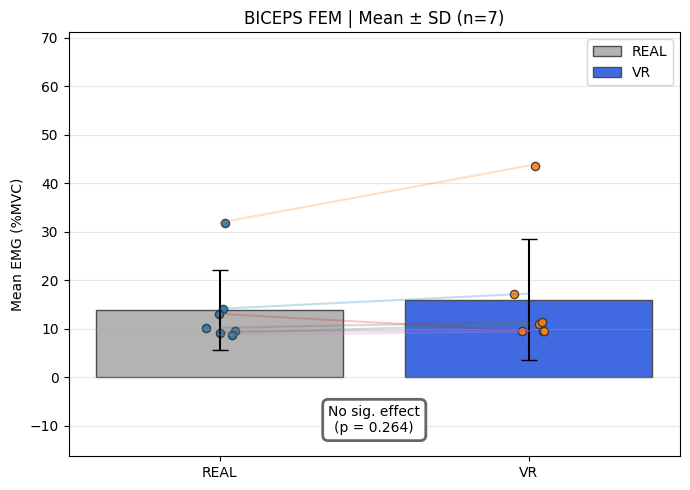

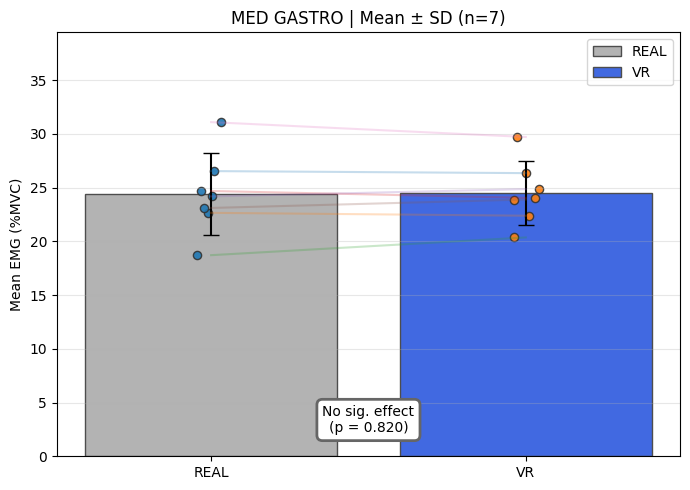

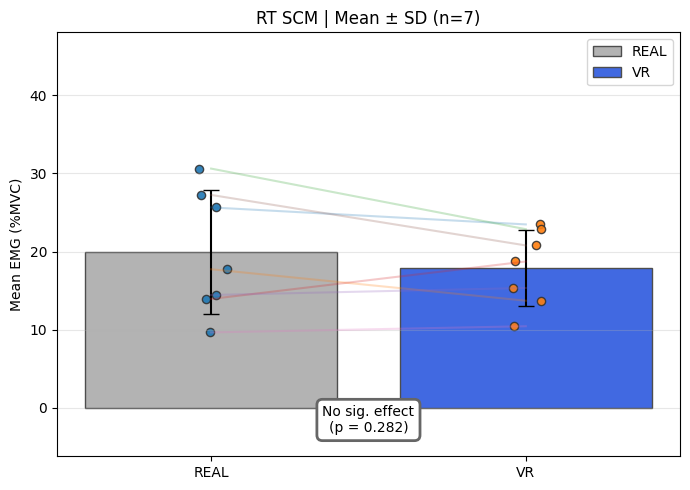

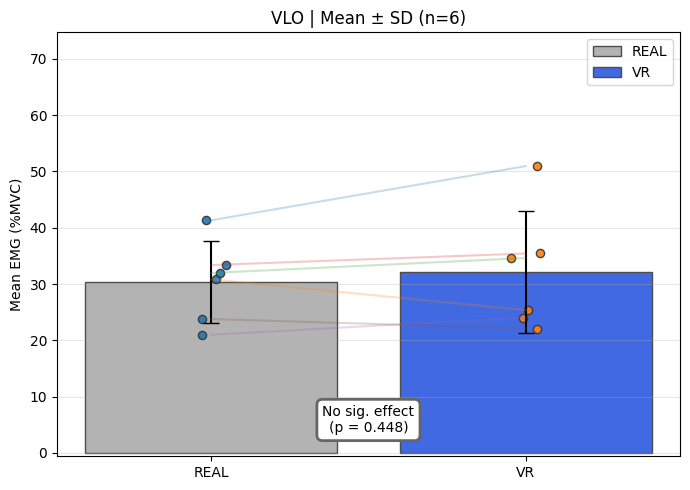

In [1]:
#%% JASP-ähnliche Tabelle + Barplot (Mean±SD) + Einzelwerte + gepaarte Linien
#   inkl. RT SCM (aus separater CSV)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# ------------------ Dateien laden ------------------
FILE_LEG = "results_tables_means_by_muscle/EMG_means_REAL_vs_VR_all_3legmuscles.csv"
FILE_SCM = "results_tables_means_by_muscle/RT_SCM_means_REAL_vs_VR_absprung_window.csv"

df_leg = pd.read_csv(FILE_LEG, sep=";")
df_scm = pd.read_csv(FILE_SCM, sep=";")

# SCM-Spalten umbenennen ins gleiche Format wie Beine (REAL_<muskel> / VR_<muskel>)
df_scm = df_scm.rename(columns={"REAL": "REAL_RT SCM", "VR": "VR_RT SCM"})

# Beide zusammenführen über Proband
df = pd.merge(df_leg, df_scm[["Proband", "REAL_RT SCM", "VR_RT SCM"]], on="Proband", how="left")

# ------------------ Paare automatisch finden: REAL_<muskel> vs VR_<muskel> ------------------
real_cols = [c for c in df.columns if c.startswith("REAL_")]
vr_cols   = [c for c in df.columns if c.startswith("VR_")]

real_map = {c.replace("REAL_", ""): c for c in real_cols}
vr_map   = {c.replace("VR_", ""): c for c in vr_cols}

muscles = sorted(set(real_map.keys()) & set(vr_map.keys()))  # gemeinsame Muskelnamen

# ------------------ Helper: Cohen's dz ------------------
def cohens_dz(diffs: np.ndarray) -> float:
    diffs = diffs[np.isfinite(diffs)]
    if diffs.size < 2:
        return np.nan
    sd = np.std(diffs, ddof=1)
    return np.mean(diffs) / sd if sd != 0 else np.nan

# ------------------ 1) Tabelle wie JASP ------------------
rows = []
for m in muscles:
    cR = real_map[m]
    cV = vr_map[m]
    sub = df[[cR, cV]].dropna()
    if len(sub) < 2:
        continue

    r = sub[cR].to_numpy(float)
    v = sub[cV].to_numpy(float)

    t, p = ttest_rel(r, v)
    dfree = len(sub) - 1
    diffs = r - v

    rows.append({
        "Measure 1": cR,
        "Measure 2": cV,
        "t": t,
        "df": dfree,
        "p": p,
        "n": len(sub),
        "mean_REAL": float(np.mean(r)),
        "mean_VR": float(np.mean(v)),
        "mean_diff (REAL-VR)": float(np.mean(diffs)),
        "SD_diff": float(np.std(diffs, ddof=1)),
        "Cohen_dz": cohens_dz(diffs),
    })

results_df = pd.DataFrame(rows)

# JASP-style Kernspalten anzeigen
jasp_like_table = results_df[["Measure 1", "Measure 2", "t", "df", "p"]].copy()
jasp_like_table

# ------------------ 2) Barplot pro Muskel: Mean±SD + Einzelwerte + gepaarte Linien + Textbox ------------------
Y_LABEL = "Mean EMG (%MVC)"  # bei SCM ist es auch %MVC (wenn du es so exportiert hast)

for m in muscles:
    cR = real_map[m]
    cV = vr_map[m]

    sub = df[[cR, cV]].dropna()
    if len(sub) < 2:
        print(f"Zu wenig Daten für {m}")
        continue

    r = sub[cR].to_numpy(float)
    v = sub[cV].to_numpy(float)

    t, p = ttest_rel(r, v)

    mean_r, sd_r = float(np.mean(r)), float(np.std(r, ddof=1))
    mean_v, sd_v = float(np.mean(v)), float(np.std(v, ddof=1))

    plt.figure(figsize=(7, 5))
    x = np.array([0, 1])

    # Bars (grau / blau wie Beispiel)
    plt.bar(x[0], mean_r, yerr=sd_r, capsize=6, color="0.7", edgecolor="0.3", label="REAL")
    plt.bar(x[1], mean_v, yerr=sd_v, capsize=6, color="royalblue", edgecolor="0.3", label="VR")

    # Einzelwerte + gepaarte Linien
    jitter = 0.05
    xr = np.full_like(r, x[0], dtype=float) + np.random.uniform(-jitter, jitter, size=r.size)
    xv = np.full_like(v, x[1], dtype=float) + np.random.uniform(-jitter, jitter, size=v.size)

    for i in range(r.size):
        plt.plot([x[0], x[1]], [r[i], v[i]], alpha=0.25)

    plt.scatter(xr, r, alpha=0.9, s=35, edgecolor="0.2")
    plt.scatter(xv, v, alpha=0.9, s=35, edgecolor="0.2")

    plt.xticks(x, ["REAL", "VR"])
    plt.ylabel(Y_LABEL)
    plt.title(f"{m} | Mean ± SD (n={len(sub)})")
    plt.grid(True, axis="y", alpha=0.3)

    # Textbox wie Beispiel
    msg = "Significant effect" if p < 0.05 else "No sig. effect"
    y_min = min(0, min(np.min(r), np.min(v)) - max(sd_r, sd_v) * 2.0)
    y_max = max(np.max(r), np.max(v)) + max(sd_r, sd_v) * 2.2
    if y_max <= y_min:
        y_max = y_min + 1

    plt.ylim(y_min, y_max)
    plt.text(
        0.5, y_min + (y_max - y_min) * 0.05,
        f"{msg}\n(p = {p:.3f})",
        ha="center", va="bottom",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="0.4", linewidth=2)
    )

    plt.legend()
    plt.tight_layout()
    plt.show()